In [ ]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import InceptionV3, ResNet50V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:

# Step 1: Unzip the Dataset
def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_path = '/content/archive (3).zip'  # Provide your dataset zip path
extract_to = '/content/dataset/'
unzip_dataset(zip_path, extract_to)

In [ ]:
import os

# Set base directory where your dataset is extracted
base_dir = '/content/dataset/ASD_v4_datasets'  # Update this path to match your dataset location

# Define paths for train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Print the paths to verify
print("Train Directory Path:", train_dir)
print("Validation Directory Path:", valid_dir)
print("Test Directory Path:", test_dir)

# Check the number of images in each folder
def print_dataset_size():
    for folder_name, folder_path in zip(['Train', 'Validation', 'Test'], [train_dir, valid_dir, test_dir]):
        if os.path.exists(folder_path):
            num_images = sum([len(files) for _, _, files in os.walk(folder_path)])
            print(f"Total images in {folder_name}: {num_images}")
        else:
            print(f"Error: {folder_name} path does not exist at {folder_path}")

print_dataset_size()


Train Directory Path: /content/dataset/ASD_v4_datasets/train
Validation Directory Path: /content/dataset/ASD_v4_datasets/valid
Test Directory Path: /content/dataset/ASD_v4_datasets/test
Total images in Train: 2526
Total images in Validation: 80
Total images in Test: 280


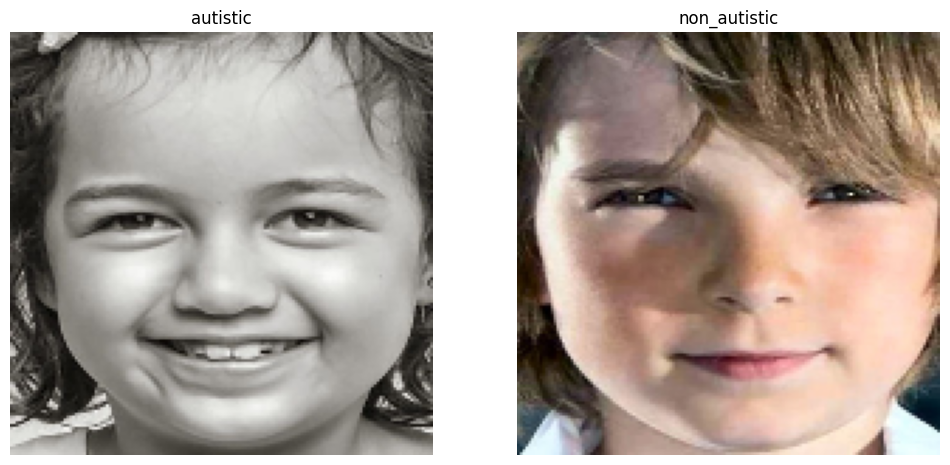

In [ ]:

# Step 3: Visualize Sample Images from Train
def visualize_samples(directory):
    categories = os.listdir(directory)
    plt.figure(figsize=(12, 6))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        img_name = os.listdir(category_path)[0]
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(cv2.resize(img, (150, 150)))
        plt.title(category)
        plt.axis('off')
    plt.show()

train_dir = os.path.join(base_dir, 'train')
visualize_samples(train_dir)


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import warnings

def preprocess_images(base_dir, img_size=(224, 224)):
    """
    Preprocess the images from the train, valid, and test folders.

    Args:
        base_dir (str): Base directory containing train, valid, and test folders.
        img_size (tuple): Target size for resizing the images.

    Returns:
        dict: Preprocessed data for train, valid, and test.
        dict: One-hot encoded labels for train, valid, and test.
    """
    data = {'train': [], 'valid': [], 'test': []}
    labels = {'train': [], 'valid': [], 'test': []}

    # Define valid image extensions
    valid_extensions = (".jpg", ".jpeg", ".png")

    # Dynamically detect class names from the training directory
    classes = [cls.lower() for cls in os.listdir(os.path.join(base_dir, 'train'))]
    print(f"Detected Classes: {classes}")

    for folder in ['train', 'valid', 'test']:
        folder_path = os.path.join(base_dir, folder)

        if not os.path.exists(folder_path):
            warnings.warn(f"Warning: Folder '{folder_path}' does not exist.")
            continue

        for class_index, class_name in enumerate(classes):
            # Handle case sensitivity by converting folder names to lowercase
            class_path = os.path.join(folder_path, class_name.lower())
            if not os.path.exists(class_path):
                warnings.warn(f"Warning: Class path '{class_path}' does not exist.")
                continue

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(valid_extensions):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img = cv2.imread(img_path)
                        if img is None:
                            warnings.warn(f"Warning: Unable to read image '{img_path}'. Skipping.")
                            continue
                        img = cv2.resize(img, img_size)
                        data[folder].append(img)
                        labels[folder].append(class_index)
                    except Exception as e:
                        warnings.warn(f"Error processing image '{img_path}': {str(e)}")
                else:
                    warnings.warn(f"Non-image file found and skipped: {img_name}")

        print(f"Processed {len(data[folder])} images for {folder} folder.")

    # Normalize data and convert labels to one-hot encoding
    for key in data:
        data[key] = np.array(data[key]) / 255.0  # Normalize pixel values
        labels[key] = to_categorical(np.array(labels[key]), num_classes=len(classes))

    return data, labels

# Base directory path
base_dir = '/content/dataset/ASD_v4_datasets'

# Call the preprocessing function
data, labels = preprocess_images(base_dir)

# Confirm dataset sizes
print(f"Train data: {len(data['train'])} images, Train labels: {len(labels['train'])}")
print(f"Valid data: {len(data['valid'])} images, Valid labels: {len(labels['valid'])}")
print(f"Test data: {len(data['test'])} images, Test labels: {len(labels['test'])}")


Detected Classes: ['autistic', 'non_autistic']
Processed 2526 images for train folder.
Processed 80 images for valid folder.


<ipython-input-11-a78dd46c833c>:57: UserWarning: Non-image file found and skipped: .ipynb_checkpoints
  warnings.warn(f"Non-image file found and skipped: {img_name}")


Processed 280 images for test folder.
Train data: 2526 images, Train labels: 2526
Valid data: 80 images, Valid labels: 80
Test data: 280 images, Test labels: 280


In [ ]:


# Step 5: Build the Hybrid Model
def build_hybrid_model(input_shape, num_classes):
    base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze layers of base models
    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False

    # Feature extraction
    inputs = Input(shape=input_shape)
    features1 = Flatten()(base_model1(inputs))
    features2 = Flatten()(base_model2(inputs))

    # Concatenate features
    merged_features = concatenate([features1, features2])

    # Classification layers
    x = Dense(256, activation='relu')(merged_features)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = len(classes)
hybrid_model = build_hybrid_model(input_shape, num_classes)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Step 6: Train and Validate the Model
history = hybrid_model.fit(
    data['train'], labels['train'],
    validation_data=(data['valid'], labels['valid']),
    epochs=5,
    batch_size=32
)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 787s 10s/step - accuracy: 0.7995 - loss: 0.4517 - val_accuracy: 0.8750 - val_loss: 0.2521
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 775s 10s/step - accuracy: 0.8547 - loss: 0.3415 - val_accuracy: 0.9250 - val_loss: 0.1763
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 791s 9s/step - accuracy: 0.9127 - loss: 0.2152 - val_accuracy: 0.9125 - val_loss: 0.1717
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 775s 10s/step - accuracy: 0.9413 - loss: 0.1660 - val_accuracy: 0.9625 - val_loss: 0.1594
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 795s 10s/step - accuracy: 0.9673 - loss: 0.1042 - val_accuracy: 0.9375 - val_loss: 0.1550


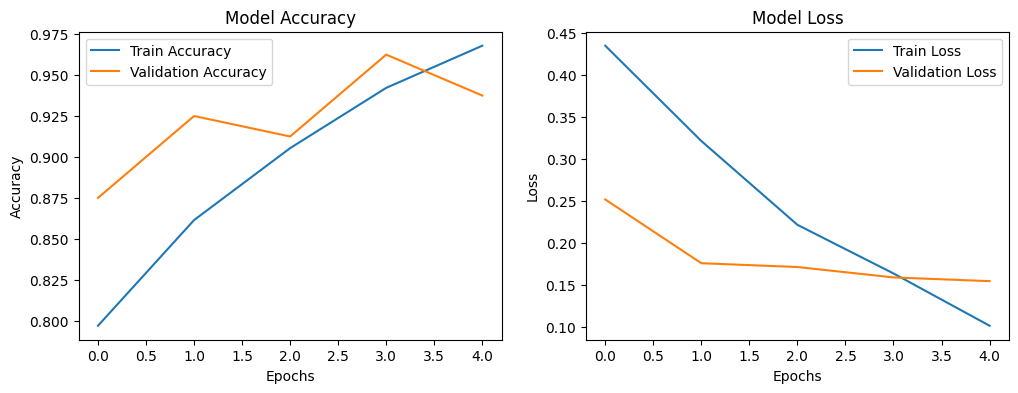

In [ ]:

# Visualize Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


In [ ]:

# Step 7: Evaluate the Model
results = hybrid_model.evaluate(data['test'], labels['test'])
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.9673 - loss: 0.0846
Test Loss: 0.13804058730602264
Test Accuracy: 95.00%


9/9 ━━━━━━━━━━━━━━━━━━━━ 96s 10s/step
Classification Report:
               precision    recall  f1-score   support

    autistic       0.92      0.99      0.95       140
non_autistic       0.98      0.91      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



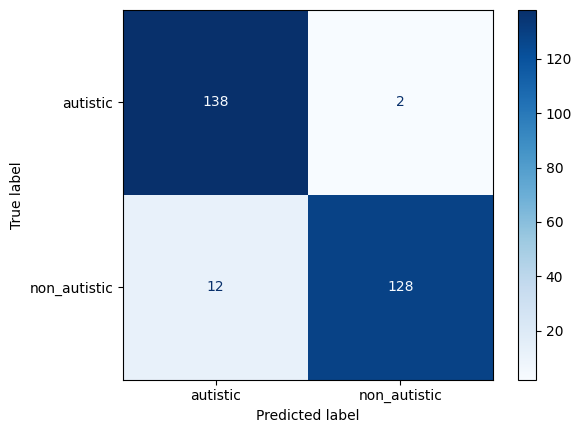

In [ ]:

# Step 8: Confusion Matrix and Classification Report
y_true = np.argmax(labels['test'], axis=1)
y_pred = np.argmax(hybrid_model.predict(data['test']), axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:

# Step 9: Test the Model with a Single Image
def test_single_image(img_path, model, classes):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    return classes[class_index], prediction

sample_image_path = '/content/dataset/ASD_v4_datasets/test/non_autistic/tna.094.jpg'  # Provide path to a sample image
predicted_class, confidence = test_single_image(sample_image_path, hybrid_model, classes)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Predicted Class: non_autistic, Confidence: [[0.00154922 0.99845076]]


In [ ]:
hybrid_model.save('inc+res.h5')


NameError: name 'hybrid_model' is not defined